_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Luca Kosina, Sascha Mühlinghaus, Max Bardelang</span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 4

In this notebook you will work with preprocessed 2 photon calcium recordings, that have already been converted into spike counts for a population of cells from the Macaque V1. During the experiment the animal has been presented with several drifting grating stimuli, in response to which the neural activity was recorded. In this exercise sheet we will study how you can visualize the activity of multiple neural spike trains and assess whether a neuron is selective to a specific stimulus type.

Download the data files ```nds_cl_4_*.csv``` from ILIAS and save it in the subfolder ```../data/```. We recommend you to use a subset of the data for testing and debugging, ideally focus on a single cell (e.g. cell number x). The spike times and stimulus conditions are read in as pandas data frames. You can solve the exercise by making heavy use of that, allowing for many quite compact computations. See [documentation](http://pandas.pydata.org/pandas-docs/stable/index.html) and several good [tutorials](https://www.datacamp.com/community/tutorials/pandas-tutorial-dataframe-python#gs.L37i87A) on how to do this. Of course, converting the data into classical numpy arrays is also valid.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.optimize as opt

from scipy import signal as signal
from typing import Tuple

import itertools

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-15 09:36:59CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.36.0

sklearn: 1.6.1

pandas    : 2.2.3
numpy     : 2.0.1
scipy     : 1.13.1
seaborn   : 0.13.2
matplotlib: 3.10.1

Watermark: 2.5.0



In [2]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [3]:
spikes = pd.read_csv("../data/nds_cl_4_spiketimes.csv")  # neuron id, spike time
stims = pd.read_csv("../data/nds_cl_4_stimulus.csv")  # stimulus onset in ms, direction

stimDur = 2000.0  # in ms
nTrials = 11  # number of trials per condition
nDirs = 16  # number of conditions
deltaDir = 22.5  # difference between conditions

stims["StimOffset"] = stims["StimOnset"] + stimDur

We require some more information about the spikes for the plots and analyses we intend to make later. With a solution based on dataframes, it is natural to compute this information here and add it as additional columns to the `spikes` dataframe by combining it with the `stims` dataframe. We later need to know which condition (`Dir`) and trial (`Trial`) a spike was recorded in, the relative spike times compared to stimulus onset of the stimulus it was recorded in (`relTime`) and whether a spike was during the stimulation period (`stimPeriod`). But there are many options how to solve this exercise and you are free to choose any of them.

In [ ]:
# you may add computations as specified above
spikes["Dir"] = np.nan
spikes["relTime"] = np.nan
spikes["Trial"] = np.nan
spikes["stimPeriod"] = np.nan

dirs = np.unique(stims["Dir"])
trialcounter = np.zeros_like(dirs)

for i, row in stims.iterrows():
    trialcounter[dirs == row["Dir"]] += 1

    # select spikes that are within the stimulus period
    i0 = spikes["SpikeTimes"] > row["StimOnset"]
    i1 = spikes["SpikeTimes"] < row["StimOffset"]
    select = i0.values & i1.values

    # assign direction, trial number and relative time (of spike to stimulus onset)
    # note: each spike implicitly can only fall into one trial
    spikes.loc[select, "Dir"] = row["Dir"]
    spikes.loc[select, "Trial"] = trialcounter[dirs == row["Dir"]][0]
    spikes.loc[select, "relTime"] = spikes.loc[select, "SpikeTimes"] - row["StimOnset"]
    spikes.loc[select, "stimPeriod"] = True

spikes = spikes.dropna()

## Task 1: Plot spike rasters

In a raster plot, each spike is shown by a small tick at the time it occurs relative to stimulus onset. Implement a function `plotRaster()` that plots the spikes of one cell as one trial per row, sorted by conditions (similar to what you saw in the lecture). Why are there no spikes in some conditions and many in others?

If you opt for a solution without a dataframe, you need to change the interface of the function.

*Grading: 3 pts*


In [5]:
def axPlotRaster(
    spikes: pd.DataFrame,
    neuron: int,
    ax: mpl.axes.Axes,
    title: str = "",
):
    """plot spike rasters for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID

    ax: mpl.axes.Axes
        Axes to plot on

    title: str
        Title of the plot
    Note
    ----

    this function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------
    # Filter spikes for the given neuron
    neuron_spikes = spikes[spikes["Neuron"] == neuron]

    # Sort spikes by direction and trial
    neuron_spikes = neuron_spikes.sort_values(by=["Dir", "Trial"])

    for i, (trial, trial_data) in enumerate(neuron_spikes.groupby(["Dir", "Trial"])):
        ax.vlines(trial_data["relTime"], i + 0.5, i + 1.5, color="black", linewidth=0.5)

    # Add labels and formatting
    ax.set_title(title)
    ax.set_yticks(
        range(
            1,
            len(neuron_spikes.groupby(["Dir", "Trial"])) + 1,
            len(neuron_spikes["Trial"].unique()),
        ),
    )
    ax.set_yticklabels(sorted(neuron_spikes["Dir"].unique()))
    ax.set_ylim(0, len(neuron_spikes.groupby(["Dir", "Trial"])) + 1)
    ax.set_xlim(0, 2000)
    ax.set_xticks(np.arange(0, 2001, 500))
    ax.set_xticklabels(np.arange(-500, 2001, 500))
    ax.set_title(title)
    ax.grid(which="both", axis="x", color="gray", linestyle="--", linewidth=0.5)
    ax.grid(which="major", axis="y", color="gray", linestyle="-", linewidth=0.5)
    ax.grid(which="minor", axis="y", color="gray", linestyle="--", linewidth=0.5)
    ax.set_axisbelow(True)

Find examples of 
1. a direction selective neuron
2. an orientation selective neuron 
3. neither

and explain your choices.

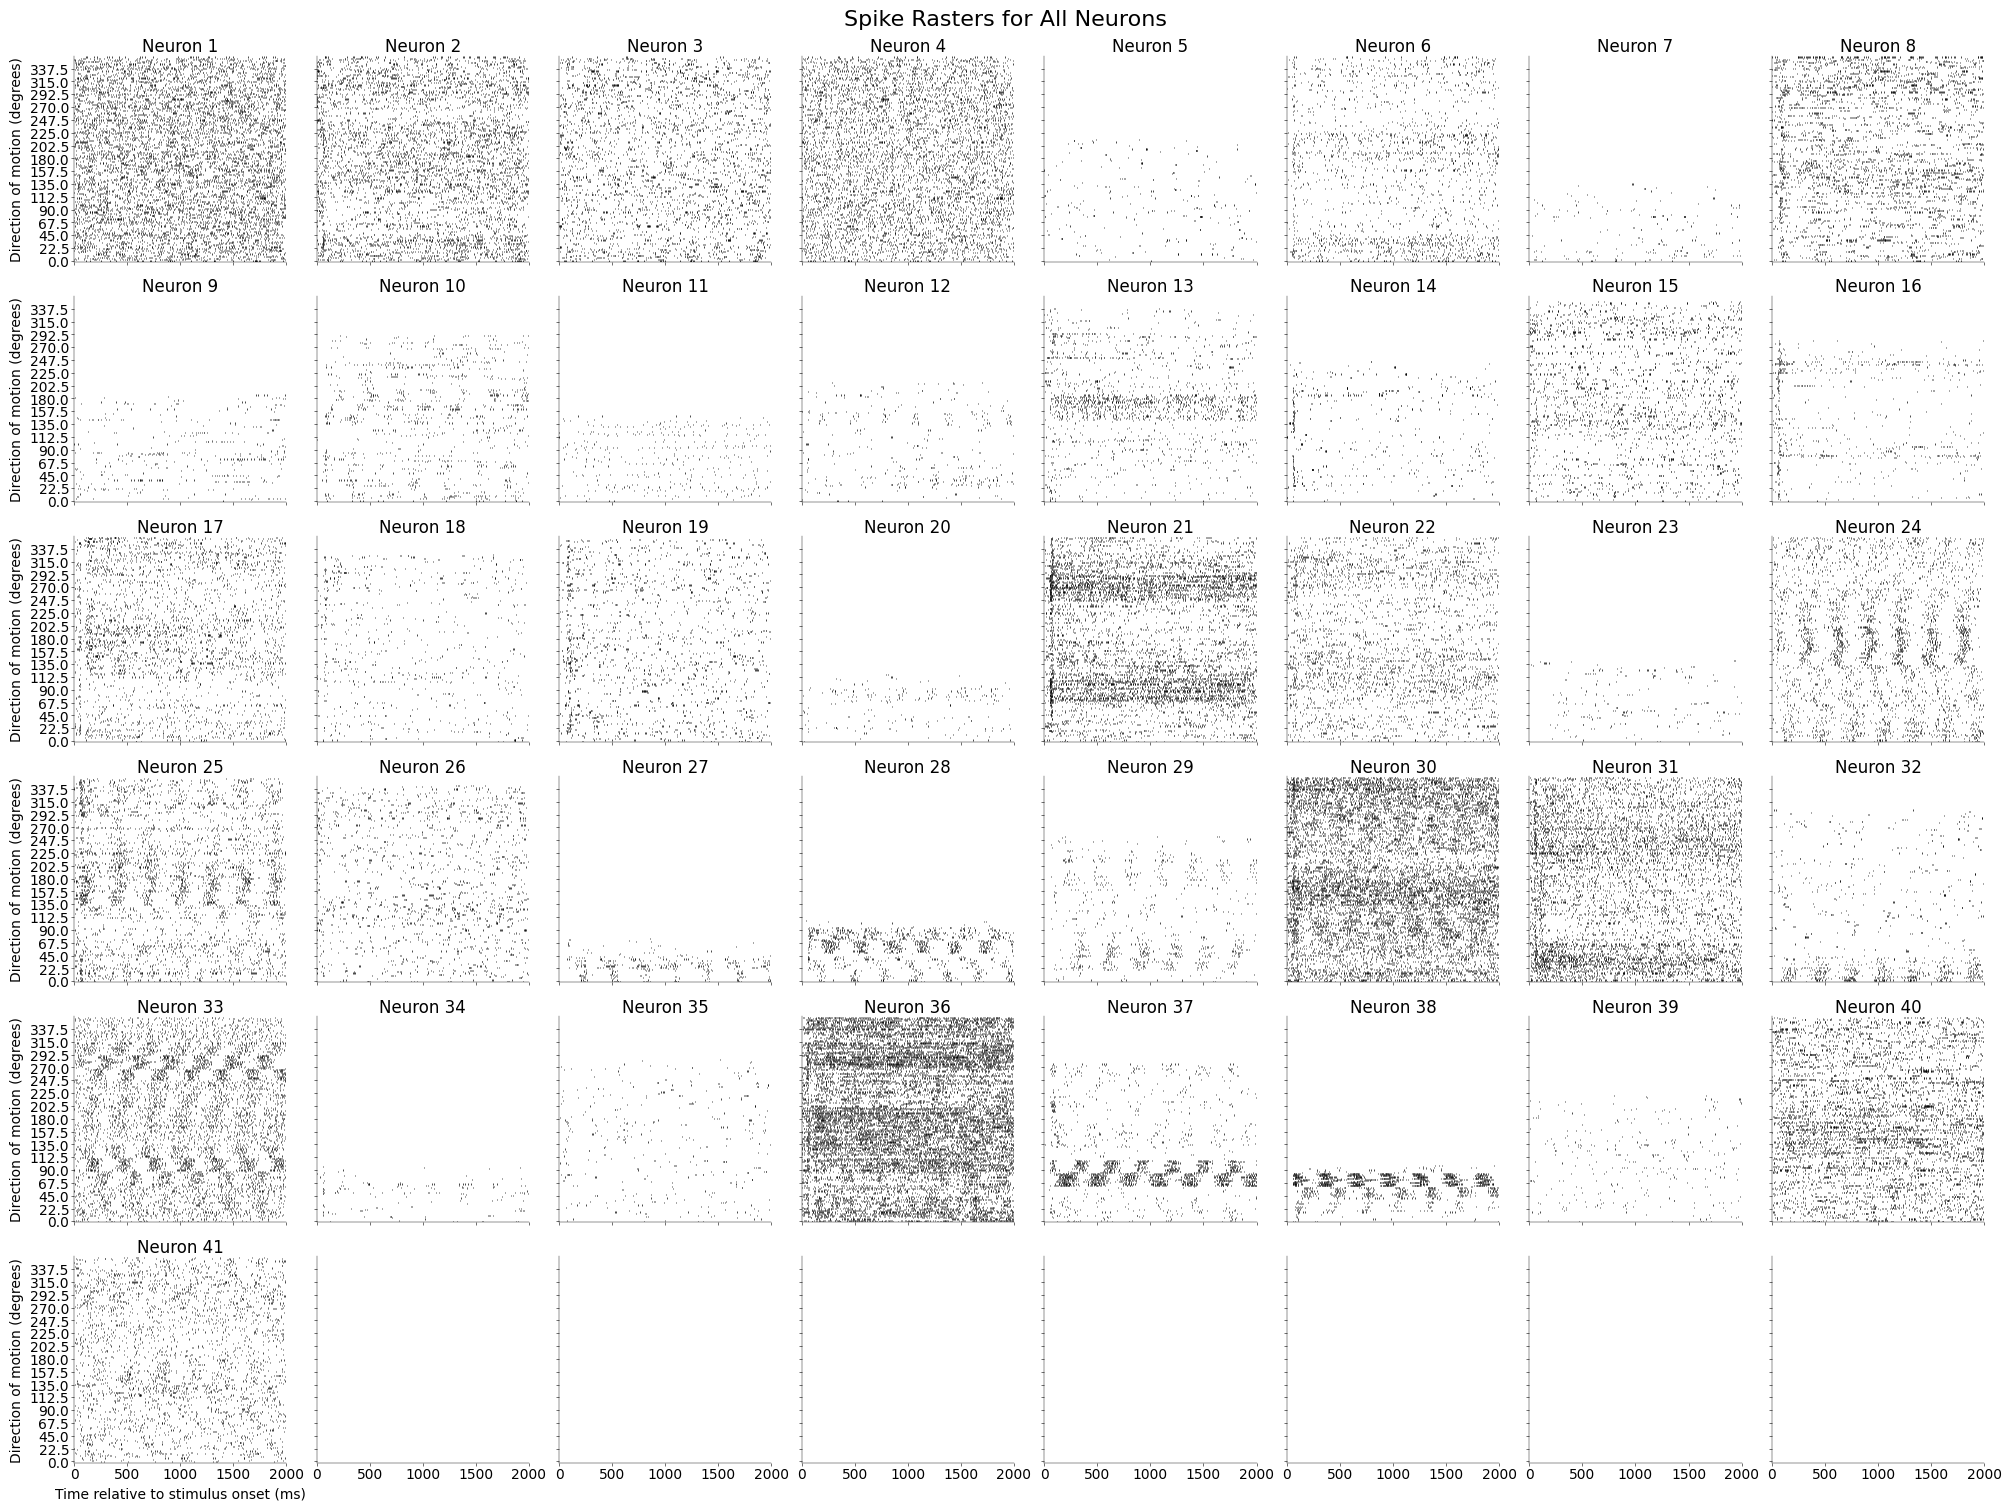

neurons not in the grid dont have spikes in the dataset


In [6]:
# ---------------------------------
# Find and explain examples? (1 pt)
# ---------------------------------
# plot rasters for all neurons on a 6x8 grid
fig, axes = plt.subplots(6, 8, figsize=(20, 15), sharex=True, sharey=True)
fig.suptitle("Spike Rasters for All Neurons", fontsize=16)
axes = axes.flatten()
for i, neuron in enumerate(spikes["Neuron"].unique()):
    ax = axes[i]
    try:
        axPlotRaster(
            spikes,
            neuron,
            ax,
            title=f"Neuron {neuron}",
        )
    except ValueError:
        pass
        # print(f"Neuron {neuron} has no spikes in the dataset.")
    # plot x axis label for the last row
    if i >= 6 * 8 - 8:
        ax.set_xlabel("Time relative to stimulus onset (ms)")
    # plot y axis label for the first column
    if i % 8 == 0:
        ax.set_ylabel("Direction of motion (degrees)")
plt.show()
print("neurons not in the grid dont have spikes in the dataset")

In [7]:
# 1) neuron 28 is direction selective, because it fires only in response to certain direction and is inhibited for every other direction (no baseline activity)
# 2) neuron 16 is orientation selective, because it fires most strongly in response to two directions that are at a 180 degree angle,
# for this neuron approximately 90 and 270 degree
# 3) neuron 4 is not direction selective, because it fires in response to all directions

## Task 2: Plot spike density functions

Compute an estimate of the spike rate against time relative to stimulus onset. There are two ways:
* Discretize time: Decide on a bin size, count the spikes in each bin and average across trials. 
* Directly estimate the probability of spiking using a density estimator with specified kernel width. 

For full points, the optimal kernel- or bin-width needs to be computed.

Implement one of them in the function `plotPSTH()`. If you dont use a dataframe you may need to change the interface of the function.


*Grading: 4 pts*


In [8]:
def plotPSTH(spikes: pd.DataFrame, neuron: int):
    """Plot PSTH for a single neuron sorted by condition

    Parameters
    ----------

    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neuron: int
        Neuron ID


    Note
    ----

    this function does not return anything, it just creates a plot!
    """
    neuron_spikes = spikes[spikes["Neuron"] == neuron]

    # -------------------------------------------------
    # Implement one of the spike rate estimates (3 pts)
    # -------------------------------------------------
    # note part of the code of this is woven into the plotting code , disentangling it would make code less readable
    def Cn(df, bin_size):
        """find optimal bni size for given spike data"""
        # optimizier potentially inputs bin_size as a list, this is a (ugly) workaround to convert to float
        try:
            _ = len(bin_size)
            bin_edges = np.arange(0, 2001, *bin_size)
        except:
            bin_edges = np.arange(0, 2001, bin_size)

        # count of spikes in each bin
        ki, _ = np.histogram(df["relTime"], bins=bin_edges)

        k_, v, n = ki.mean(), ki.var(), df.Trial.unique().size
        return (2 * k_ - v) / (n * bin_size / 1000) ** 2  # convert bin size to seconds

    # ---------------------------------------------
    # Plot the obtained spike rate estimates (1 pt)
    # ---------------------------------------------
    # calculate maximum value ki will take on
    scaling = 1
    for name, group in neuron_spikes.groupby(["Dir"]):
        bin_size = opt.brute(lambda bs: Cn(group, bs), [(10, 200)])
        bin_edges = np.arange(0, 2001, *bin_size)
        ki, _ = np.histogram(group["relTime"], bins=bin_edges)
        max_ki = ki.max()
        if max_ki > scaling:
            scaling = max_ki
    # scale the y axis to the maximum value of ki
    scaling = scaling * 1.2 / 22.5  # scale to 22.5 degree steps

    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(10, 5))
    # Left subplot for directions 0 to <180
    for name, group in neuron_spikes.groupby(["Dir"]):
        if name[0] < 180:
            bin_size = opt.brute(lambda bs: Cn(group, bs), [(10, 200)])
            bin_edges = np.arange(0, 2001, *bin_size)
            ki, _ = np.histogram(group["relTime"], bins=bin_edges)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax_left.bar(
                bin_centers,
                ki / scaling,
                width=bin_size,
                bottom=name,
                label=f"{name}°",
                alpha=0.8,
                color="black",
                edgecolor="none",
            )
    ax_left.set_ylabel("Direction of motion (degrees)")
    ax_left.set_xlabel("Time relative to stimulus onset (ms)")
    ax_left.set_title(f"PSTH for Neuron {neuron} (0° to <180°)")
    ax_left.set_xlim(0, 2000)
    ax_left.set_yticks(np.arange(0, 180, 22.5))
    ax_left.set_yticklabels(np.arange(0, 180, 22.5))
    ax_left.set_ylim(0, 180)
    ax_left.set_xticks(np.arange(0, 2001, 500))
    ax_left.set_xticklabels(np.arange(0, 2001, 500))
    ax_left.grid(which="both", axis="y", color="gray", linestyle="-", linewidth=0.5)

    # Right subplot for directions 180 to 360
    for name, group in neuron_spikes.groupby(["Dir"]):
        if name[0] >= 180:
            bin_size = opt.brute(lambda bs: Cn(group, bs), [(10, 200)])
            bin_edges = np.arange(0, 2001, *bin_size)
            ki, _ = np.histogram(group["relTime"], bins=bin_edges)
            bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
            ax_right.bar(
                bin_centers,
                ki / scaling,
                width=bin_size,
                bottom=name,
                label=f"{name}°",
                alpha=0.8,
                color="black",
                edgecolor="none",
            )
    ax_right.set_xlabel("Time relative to stimulus onset (ms)")
    ax_right.set_title(f"PSTH for Neuron {neuron} (180° to 360°)")
    ax_right.set_xlim(0, 2000)
    ax_right.set_ylim(180, 360)
    ax_right.set_xticks(np.arange(0, 2001, 500))
    ax_right.set_xticklabels(np.arange(0, 2001, 500))
    ax_right.set_yticks(np.arange(180, 361, 22.5))
    ax_right.set_yticklabels(np.arange(180, 361, 22.5))
    ax_right.grid(which="both", axis="y", color="gray", linestyle="-", linewidth=0.5)

    plt.show()

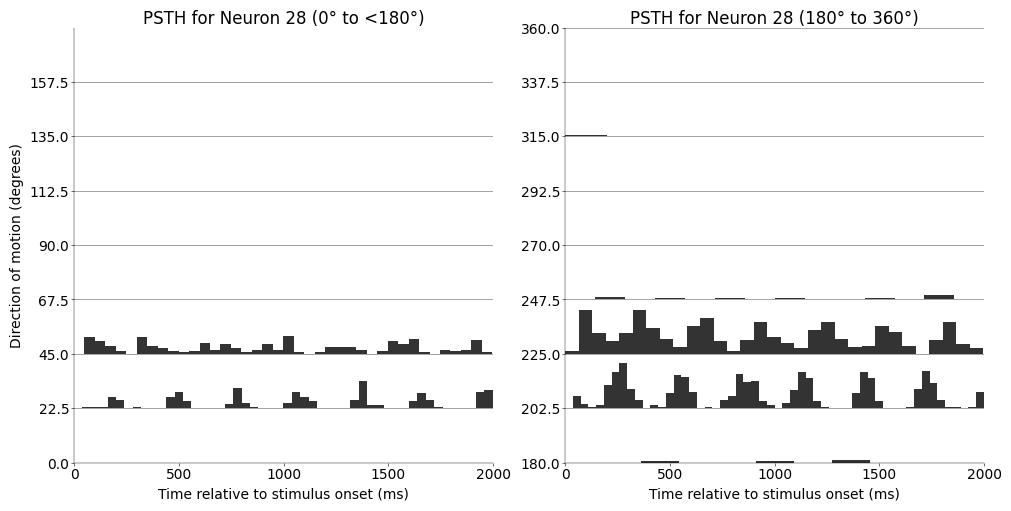

In [9]:
plotPSTH(spikes, 28)

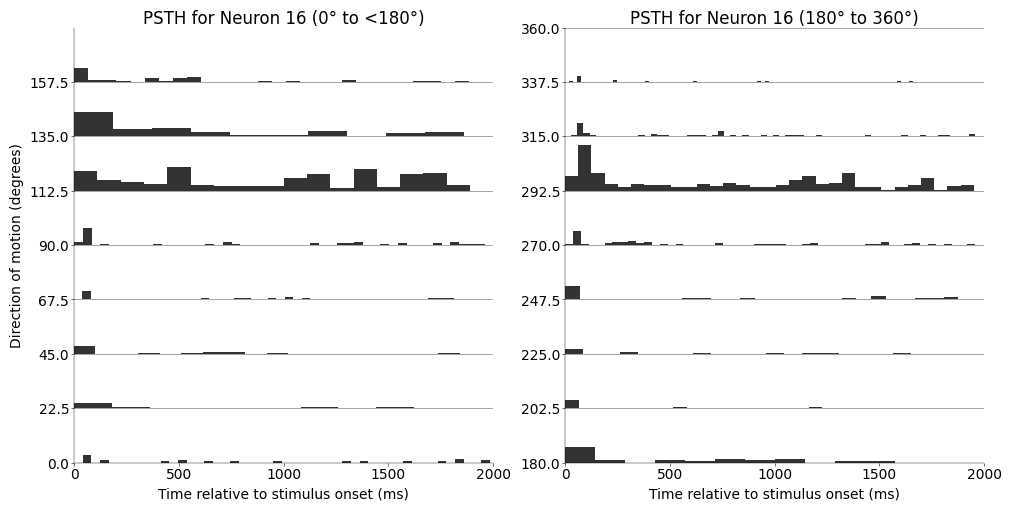

In [10]:
plotPSTH(spikes, 16)

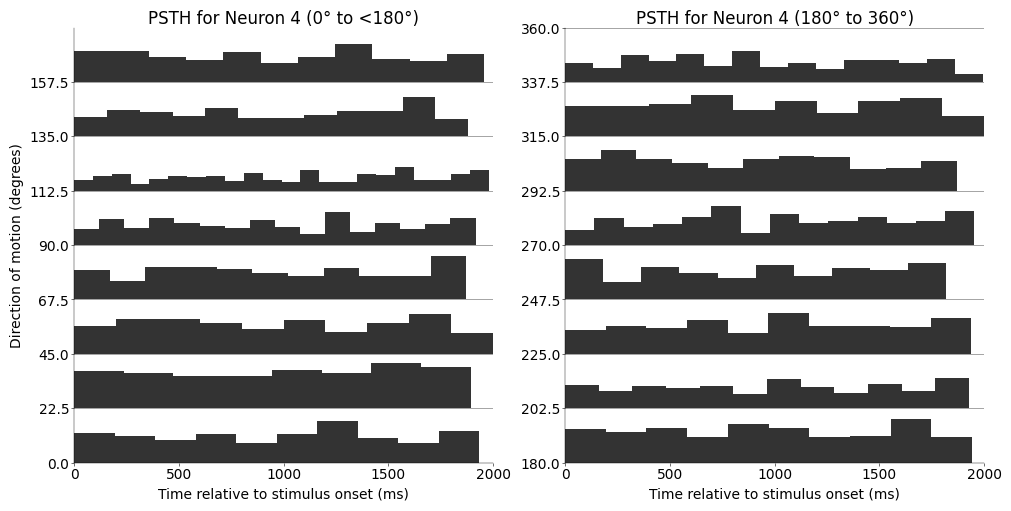

In [11]:
plotPSTH(spikes, 4)

Plot the same 3 examples you selected in Task 1

## Task 3: Fit and plot tuning functions

The goal is to visualize the activity of each neuron as a function of stimulus direction. First, compute the spike counts of each neuron for each direction of motion and trial.  The result should be a matrix `x`, where $x_{jk}$ represents the spike count of the $j$-th response to the $k$-th direction of motion (i.e. each column contains the spike counts for all trials with one direction of motion).	If you used dataframes above, the `groupby()` function allows to implement this very compactly. Make sure you don't loose trials with zero spikes though. Again, other implementations are completely fine.

Fit the tuning curve, i.e. the average spike count per direction, using a von Mises model. To capture the non-linearity and direction selectivity of the neurons, we will fit a modified von Mises function:

$$ f(\theta) = \exp(\alpha + \kappa (\cos (2*(\theta-\phi))-1) + \nu (\cos (\theta-\phi)-1))$$

Here, $\theta$ is the stimulus direction. Implement the von Mises function in `vonMises()` and plot it to understand how to interpret its parameters $\phi$, $\kappa$, $\nu$, $\alpha$. Perform a non-linear least squares fit using a package/function of your choice. Implement the fitting in `tuningCurve()`. 

Plot the average number of spikes per direction, the spike counts from individual trials as well as your optimal fit.

Select two cells that show nice tuning to test your code.

*Grading: 5 pts*

In [12]:
def vonMises(
    theta: np.ndarray, alpha: float, kappa: float, ny: float, phi: float
) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    # -----------------------------------
    # Implement the Mises model (0.5 pts)
    # -----------------------------------
    theta, phi = np.deg2rad(theta), np.deg2rad(phi)

    return np.exp(
        alpha + kappa * (np.cos(2 * (theta - phi)) - 1) + ny * (np.cos(theta - phi) - 1)
    )

Plot the von Mises function while varying the parameters systematically.

In [ ]:
# ------------------------------------------------------------------------------
# plot von Mises curves with varying parameters and explain what they do (2 pts)
# ------------------------------------------------------------------------------
# initial parameters
alpha = 0.0
kappa = 1.0
ny = 0.5
phi = 279.0
# theta values
theta = np.linspace(0, 360, 1000)

# vary alpha
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Von Mises Tuning Curves, varying alpha", fontsize=16)
axes = axes.flatten()
# plot with varying alpha
alpha_values = [0.0, 1.0, 2.0, 3.0]
for i, alpha in enumerate(alpha_values):
    axes[i].plot(theta, vonMises(theta, alpha, kappa, ny, phi))
    axes[i].set_title(f"Alpha = {alpha}")
    axes[i].set_xlabel("Theta (degrees)")
    axes[i].set_ylabel("f(Theta)")
    axes[i].set_ylim(0, 10)
    axes[i].grid()
alpha = 1.0


# vary kappa
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Von Mises Tuning Curves, varying kappa", fontsize=16)
axes = axes.flatten()
# plot with varying kappa
kappa_values = [0.0, 1.0, 3.0, 10.0]
for i, kappa in enumerate(kappa_values):
    axes[i].plot(theta, vonMises(theta, alpha, kappa, ny, phi))
    axes[i].set_title(f"Kappa = {kappa}")
    axes[i].set_xlabel("Theta (degrees)")
    axes[i].set_ylabel("f(Theta)")
    axes[i].set_ylim(0, 10)
    axes[i].grid()
kappa = 1.0

# vary ny
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Von Mises Tuning Curves, varying ny", fontsize=16)
axes = axes.flatten()
# plot with varying ny
ny_values = [0.0, 1.0, 2.0, 3.0]
for i, ny in enumerate(ny_values):
    axes[i].plot(theta, vonMises(theta, alpha, kappa, ny, phi))
    axes[i].set_title(f"Ny = {ny}")
    axes[i].set_xlabel("Theta (degrees)")
    axes[i].set_ylabel("f(Theta)")
    axes[i].set_ylim(0, 10)
    axes[i].grid()
ny = 0.5


# vary phi
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle("Von Mises Tuning Curves, varying phi", fontsize=16)
axes = axes.flatten()
# plot with varying phi
phi_values = [0.0, 90.0, 180.0, 270.0]
for i, phi in enumerate(phi_values):
    axes[i].plot(theta, vonMises(theta, alpha, kappa, ny, phi))
    axes[i].set_title(f"Phi = {phi}")
    axes[i].set_xlabel("Theta (degrees)")
    axes[i].set_ylabel("f(Theta)")
    axes[i].set_ylim(0, 10)
    axes[i].grid()

ANSWER:

alpha: proportionally scales values

kappa: sharpens peaks

ny: suppresses second peak

phi: shifts function along Theta

In [14]:
def tuningCurve(counts: np.ndarray, dirs: np.ndarray, show: bool = True) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """

    # ----------------------------------------
    # Compute the spike count matrix (0.5 pts)
    # ----------------------------------------
    # preserve all combinations
    # all_combinations = pd.MultiIndex.from_product(
    #     [
    #         counts.index.get_level_values("Dir").unique(),
    #         counts.index.get_level_values("Trial").unique(),
    #     ],
    #     names=["Dir", "Trial"],
    # )

    # counts = (
    #     counts.groupby(["Dir", "Trial"])
    #     .size()
    #     .reindex(all_combinations, fill_value=0)  # include all combinations
    #     .unstack("Trial")
    # )

    # ------------------------------------------------------------
    # fit the von Mises tuning curve to the spike counts (0.5 pts)
    # ------------------------------------------------------------
    (alpha, kappa, ny, phi), _ = opt.curve_fit(vonMises, dirs, counts, maxfev=100000)

    if show:
        # --------------------------------------------
        # plot the data and fitted tuning curve (1 pt)
        # --------------------------------------------
        theta = np.linspace(0, 360, 1000)
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(f"Von Mises Tuning Curve for Neuron {neuron}", fontsize=16)
        ax.plot(dirs, counts.mean(axis=1), "o", label="Data")
        ax.plot(theta, vonMises(theta, alpha, kappa, ny, phi), label="Fitted Curve")
        ax.set_xlabel("Direction (degrees)")
        ax.set_ylabel("Spike Count")
        ax.set_title(
            f"Alpha: {alpha:.2f}, Kappa: {kappa:.2f}, Ny: {ny:.2f}, Phi: {phi:.2f}"
        )
        ax.set_xlim(0, 360)
        ax.set_ylim(0, counts.max() * 1.2)
        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xticklabels(np.arange(0, 361, 45))
        ax.set_yticks(np.arange(0, counts.max() * 1.2, 5))
        ax.set_yticklabels(np.arange(0, counts.max() * 1.2, 5))
        ax.grid()
        ax.legend()
        plt.show()
    return np.array([alpha, kappa, ny, phi])

Plot tuning curve and fit for different neurons. Good candidates to check are 28, 29 or 37. 

In [15]:
def get_data(spikes, neuron):
    spk_by_dir = (
        spikes[spikes["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])["stimPeriod"]
        .sum()
        .astype(int)
        .reset_index()
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["stimPeriod"].values

    # because we count spikes only when they are present, some zero entries in the count vector are missing
    for i, Dir in enumerate(np.unique(spikes["Dir"])):
        m = nTrials - np.sum(dirs == Dir)
        if m > 0:
            dirs = np.concatenate((dirs, np.ones(m) * Dir))
            counts = np.concatenate((counts, np.zeros(m)))

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]  # sorted dirs
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted

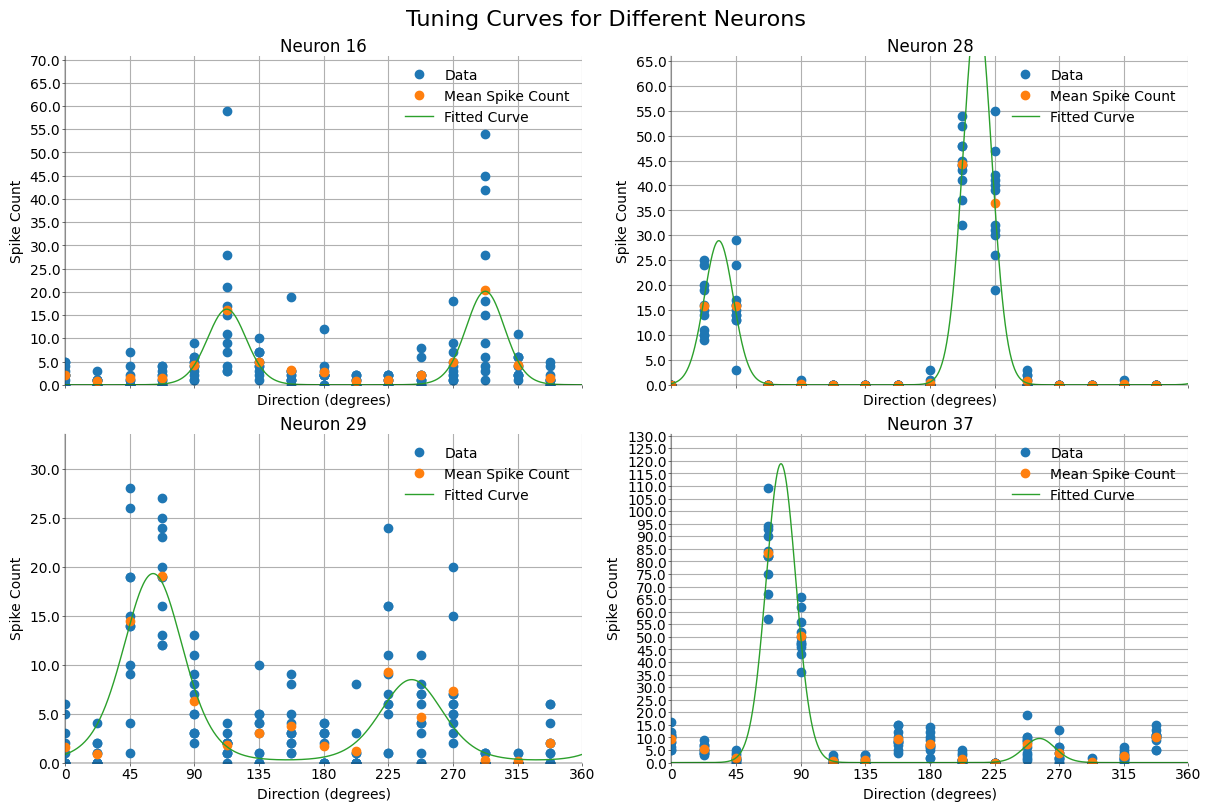

In [16]:
# ----------------------------------------------------------
# plot the average number of spikes per direction, the spike
# counts from individual trials as well as your optimal fit
# for different neurons (0.5 pts)
# ----------------------------------------------------------

# plot tuning curves for different neurons
neurons = [
    16,
    28,
    29,
    37,
]

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Tuning Curves for Different Neurons", fontsize=16)
axes = axes.flatten()
for i, neuron in enumerate(neurons):
    ax = axes[i]
    dirs, counts = get_data(spikes, neuron)

    unique_dirs = np.sort(np.unique(dirs))

    df = pd.DataFrame({"Counts": counts}, index=dirs).groupby(level=0).mean()
    α0 = np.log(np.max(df.values.flatten()) + 1e-3)
    ϕ0 = unique_dirs[np.argmax(df.values.flatten())]
    p0 = [α0, 1.0, 1.0, ϕ0]

    p, _ = opt.curve_fit(
        vonMises, df.index.values, df.values.flatten(), p0=p0, maxfev=10000
    )
    ax.plot(dirs, counts, "o", label="Data")
    ax.plot(df.index.values, df.values.flatten(), "o", label="Mean Spike Count")
    theta = np.linspace(0, 360, 1000)
    ax.plot(theta, vonMises(theta, *p), label="Fitted Curve")
    ax.set_title(f"Neuron {neuron}")
    ax.set_xlabel("Direction (degrees)")
    ax.set_ylabel("Spike Count")
    ax.set_xlim(0, 360)
    ax.set_ylim(0, counts.max() * 1.2)
    ax.set_xticks(np.arange(0, 361, 45))
    ax.set_xticklabels(np.arange(0, 361, 45))
    ax.set_yticks(np.arange(0, counts.max() * 1.2, 5))
    ax.set_yticklabels(np.arange(0, counts.max() * 1.2, 5))
    ax.grid()
    ax.legend()

## Task 4: Permutation test for direction tuning

Implement a permutation test to quantitatively assess whether a neuron is direction/orientation selective. To do so, project the vector of average spike counts, $m_k=\frac{1}{N}\sum_j x_{jk}$ on a complex exponential with two cycles, $v_k = \exp(\psi i \theta_k)$, where $\theta_k$ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the fourier component to test (1: direction, 2: orientation). Denote the projection by $q=m^Tv$. The magnitude $|q|$ tells you how much power there is in the $\psi$-th fourier component. 

Estimate the distribution of |q| under the null hypothesis that the neuron fires randomly across directions by running 1000 iterations where you repeat the same calculation as above but on a random permutation of the trials (that is, randomly shuffle the entries in the spike count matrix x). The fraction of iterations for which you obtain a value more extreme than what you observed in the data is your p-value. Implement this procedure in the function ```testTuning()```. 

Illustrate the test procedure for one of the cells from above. Plot the sampling distribution of |q| and indicate the value observed in the real data in your plot. 

How many cells are tuned at p < 0.01?

*Grading: 3 pts*


In [ ]:
def spikecount_matrix(spikes, neuron_id):

    # Filter spikes for the selected neuron
    spk = spikes[spikes["Neuron"] == neuron_id]

    # Create all possible combinations of Dir and Trial
    all_combinations = pd.MultiIndex.from_product(
        [np.sort(spk["Dir"].unique()), np.arange(1, nTrials + 1)],
        names=["Dir", "Trial"],
    )

    # Count spikes for each (Dir, Trial) combination
    spike_counts = (
        spk.groupby(["Dir", "Trial"])
        .size()
        .reindex(all_combinations, fill_value=0)
        .unstack("Trial")
    )

    spike_counts_df = spike_counts
    spike_counts_df.index.name = "Dir"
    spike_counts_df.columns.name = "Trial"
    return spike_counts_df

In [128]:
def shuffle_matrix(matrix_df):
    shuffled = matrix_df.copy()
    shuffled_values = np.random.permutation(shuffled.values.flatten())
    shuffled.loc[:, :] = shuffled_values.reshape(shuffled.shape)
    return shuffled

In [ ]:
m = spike_counts_df.mean(axis=1)
theta = np.deg2rad(m.index.values)
power_1st = np.abs(m.T @ np.exp(theta * 1j * 1))
power_2nd = np.abs(m.T @ np.exp(theta * 1j * 2))
m

In [134]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """
    # -------------------------------
    # calculate m, nu and q (0.5 pts)
    # -------------------------------

    # calculate vector of average spike counts for each unique direction
    unique_dirs = np.sort(np.unique(dirs))
    m = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])

    # define complex exponential vector with fourier component [1, 2]
    v = np.exp(1j * psi * np.deg2rad(unique_dirs))

    # compute observed projection
    q = np.dot(m, v)
    q_mag = np.abs(q)

    # -------------------------------------------------------------------------
    # Estimate the distribution of q under the H0 and obtain the p value (1 pt)
    # -------------------------------------------------------------------------
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)
    for i in range(niters):
        # shuffle the counts across trials
        shuffled_counts = rng.permutation(counts)
        # recompute average spike counts for each direction using shuffled data
        m_perm = np.array([np.mean(shuffled_counts[dirs == d]) for d in unique_dirs])
        # compute projection for shuffled data
        q_perm = np.dot(m_perm, v)
        qdistr[i] = np.abs(q_perm)

    # calculate the p-value as the fraction of permuted |q| more extreme than observed
    p = np.mean(qdistr > q_mag)

    # if show is true, plot the null distribution and the observed value
    if show:
        plt.figure(figsize=(8, 5))
        plt.hist(qdistr, bins=30, alpha=0.7, label="null distribution")
        plt.axvline(q_mag, color="red", linestyle="--", label="observed |q|")
        plt.xlabel("|q|")
        plt.ylabel("frequency")
        plt.title(f"Permutation test (psi = {psi})\np-value = {p:.4f}")
        plt.legend()
        plt.show()

    return p, q_mag, qdistr

Show null distribution for the example cell:

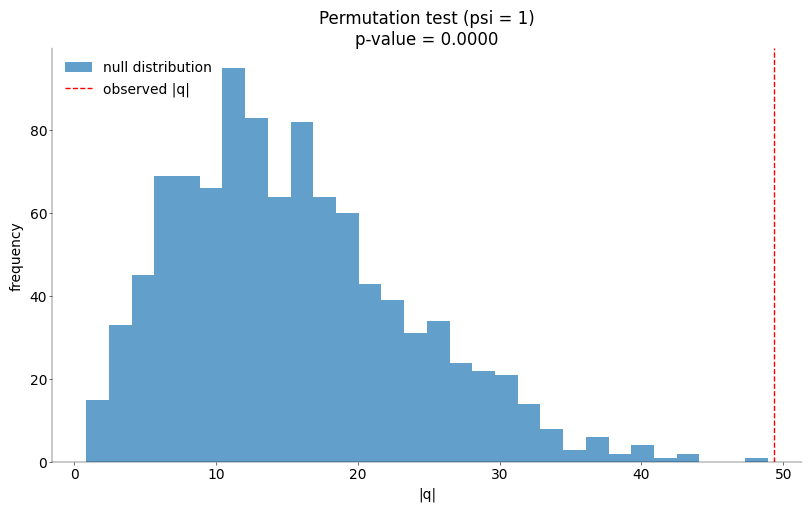

Neuron 28: p-value = 0.0000, |q| = 49.3461


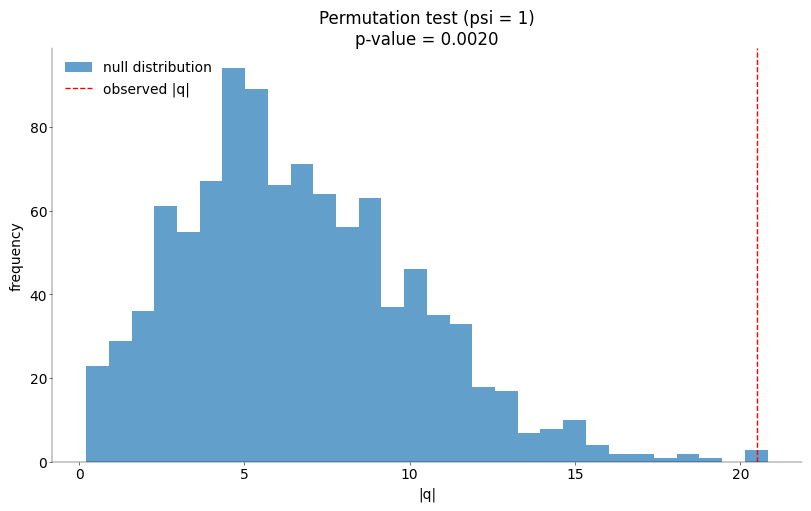

Neuron 29: p-value = 0.0020, |q| = 20.5138


In [ ]:
# ---------------------------------------------------------
# Plot null distributions for example cells 28 & 29. (1 pt)
# ---------------------------------------------------------

neurons = [28, 29]
for neuron in neurons:
    dirs, counts = get_data(spikes, neuron)
    p, q, qdistr = testTuning(counts, dirs, show=True)
    print(f"Neuron {neuron}: p-value = {p:.4f}, |q| = {q:.4f}")

Test all cells for orientation and direction tuning

In [ ]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning.
# Which ones are selective? (0.5 pts)
# --------------------------------------------------

# get unique neurons
neurons = spikes.Neuron.unique()
# create a DataFrame to store the results
results = pd.DataFrame(
    columns=[
        "Neuron",
        "p-value (direction)",
        "p-value (orientation)",
        "|q| (direction)",
        "|q| (orientation)",
    ]
)
# create lists to store results
p_values_dir = []
p_values_ori = []
q_values_dir = []
q_values_ori = []
# loop through all neurons and test for direction tuning
for neuron in neurons:
    dirs, counts = get_data(spikes, neuron)
    p_dir, q_dir, _ = testTuning(counts, dirs, psi=1, show=False)
    p_ori, q_ori, _ = testTuning(counts, dirs, psi=2, show=False)
    # append results to lists
    p_values_dir.append(p_dir)
    p_values_ori.append(p_ori)
    q_values_dir.append(q_dir)
    q_values_ori.append(q_ori)

# make dataframe
results = pd.DataFrame(
    {
        "Neuron": neurons,
        "p-value (direction)": p_values_dir,
        "p-value (orientation)": p_values_ori,
        "|q| (direction)": q_values_dir,
        "|q| (orientation)": q_values_ori,
    },
)

In [139]:
# add a column for significance
results["Significant (direction)"] = results["p-value (direction)"] < 0.01
results["Significant (orientation)"] = results["p-value (orientation)"] < 0.01
results

,Neuron,p-value (direction),p-value (orientation),|q| (direction),|q| (orientation),Significant (direction),Significant (orientation)
0,1,0.871,0.699,5.684175,8.923779,False,False
1,2,0.484,0.000,13.188314,69.584958,False,True
2,3,0.086,0.002,16.616565,27.711406,False,True
3,4,0.792,0.012,5.360472,23.285203,False,False
4,5,0.015,0.039,5.542746,4.799005,False,False
5,6,0.116,0.000,19.423996,79.765526,False,True
6,7,0.295,0.000,3.554301,12.721692,False,True
7,8,0.610,0.000,12.447186,81.147705,False,True
8,9,0.134,0.283,7.641973,6.534828,False,False
9,10,0.324,0.002,8.790470,20.855551,False,True


Number of direction tuned neurons:

In [ ]:
print(
    "The following neurons are selective for direction: ",
    results.loc[results["Significant (direction)"], "Neuron"].values,
)

The following neurons are selective for direction:  [13 20 24 25 27 28 29 31 32 37 38 40]


Number of orientation tuned neurons:

In [141]:
print(
    "The following neurons are selective for orientation: ",
    results.loc[results["Significant (orientation)"], "Neuron"].values,
)

The following neurons are selective for orientation:  [ 2  3  6  7  8 10 12 13 14 15 16 17 18 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 36 37 38 39 40 41]


In [143]:
results

,Neuron,p-value (direction),p-value (orientation),|q| (direction),|q| (orientation),Significant (direction),Significant (orientation)
0,1,0.871,0.699,5.684175,8.923779,False,False
1,2,0.484,0.000,13.188314,69.584958,False,True
2,3,0.086,0.002,16.616565,27.711406,False,True
3,4,0.792,0.012,5.360472,23.285203,False,False
4,5,0.015,0.039,5.542746,4.799005,False,False
5,6,0.116,0.000,19.423996,79.765526,False,True
6,7,0.295,0.000,3.554301,12.721692,False,True
7,8,0.610,0.000,12.447186,81.147705,False,True
8,9,0.134,0.283,7.641973,6.534828,False,False
9,10,0.324,0.002,8.790470,20.855551,False,True


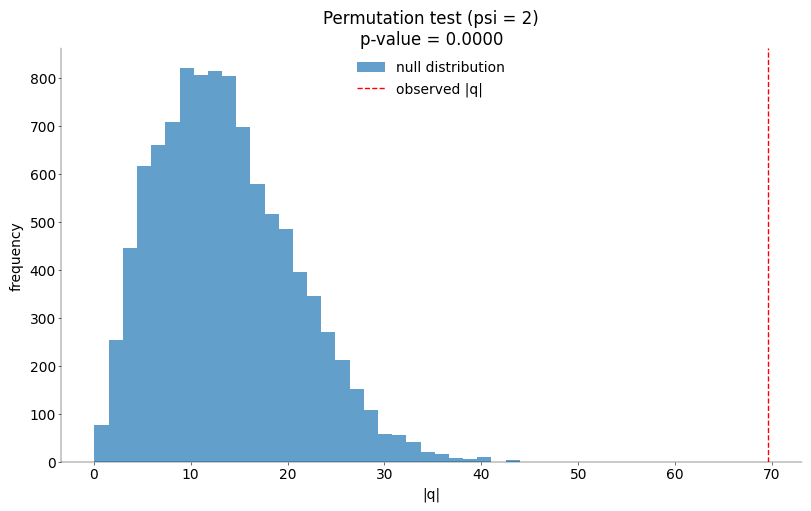

In [149]:
dirs, counts = get_data(spikes, 2)
p, q, qdistr = testTuning(counts, dirs, psi=2, niters=10000, show=True)